# Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pandas import read_csv, unique

import numpy as np

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from keras.layers import Conv1D, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Data Load

In [ ]:
def read_data(filepath):
    df = read_csv(filepath, header=None, names=['user-id',
                            'activity',
                            'timestamp',
                            'X',
                            'Y',
                            'Z'])
    ## removing ';' from last column and converting it to float
    df['Z'].replace(regex=True, inplace=True, to_replace=r';', value=r'')
    df['Z'] = df['Z'].apply(convert_to_float)
    #     df.dropna(axis=0, how='any', inplace=True)
    return df


def convert_to_float(x):
    try:
        return np.float64(x)
    except:
        return np.nan

In [ ]:
df = read_data('/content/drive/MyDrive/dataset/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt')
df

,user-id,activity,timestamp,X,Y,Z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,9.000000,-1.570000,1.690000
1098200,19,Sitting,131623371431000,9.040000,-1.460000,1.730000
1098201,19,Sitting,131623411592000,9.080000,-1.380000,1.690000
1098202,19,Sitting,131623491487000,9.000000,-1.460000,1.730000


# Data Visualization

Walking       424398
Jogging       342176
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
Name: activity, dtype: int64


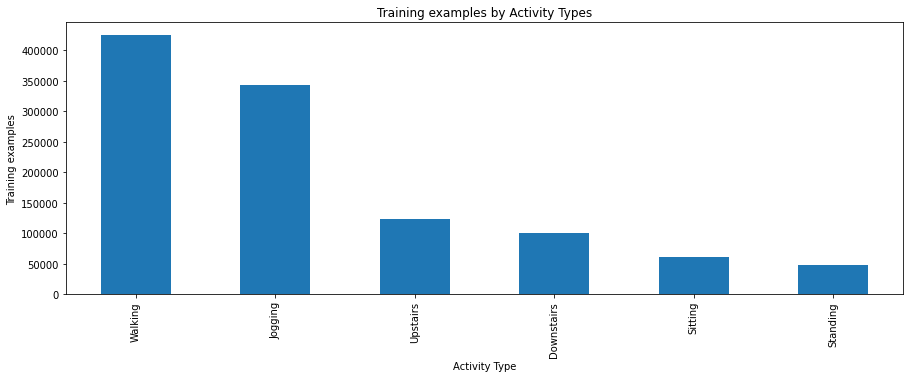

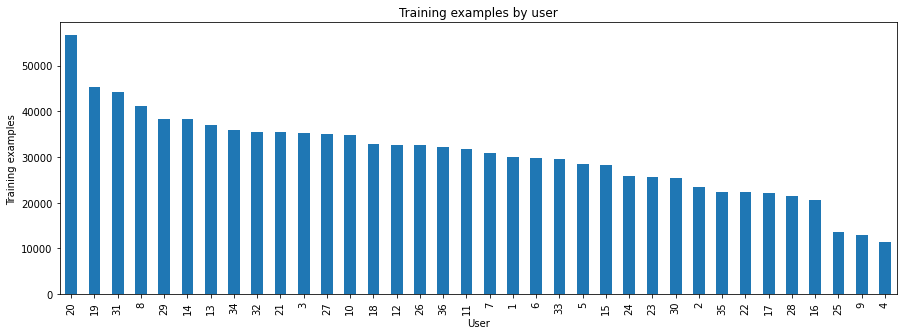

In [ ]:

plt.figure(figsize=(15, 5))
# 绘制图表
plt.xlabel('Activity Type')
plt.ylabel('Training examples')
# 将对应的activity数量绘制
print(df['activity'].value_counts())
df['activity'].value_counts().plot(kind='bar',title='Training examples by Activity Types')
plt.show()
# 将对应的用户对应的活动数量绘制
plt.figure(figsize=(15, 5))
plt.xlabel('User')
plt.ylabel('Training examples')
df['user-id'].value_counts().plot(kind='bar',title='Training examples by user')
plt.show()

In [ ]:
def axis_plot(ax, x, y, title):
    ax.plot(x, y, 'r')
    ax.set_title(title)
    # 不显示x轴的刻度线
    ax.xaxis.set_visible(False)
    # 显示y轴的数据范围
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    # 显示x轴的数据范围
    ax.set_xlim([min(x), max(x)])
    # 显示表格线
    ax.grid(True)

In [ ]:
df['activity'].unique()

array(['Jogging', 'Walking', 'Upstairs', 'Downstairs', 'Sitting',
       'Standing'], dtype=object)

0           True
1           True
2           True
3           True
4           True
           ...  
1098199    False
1098200    False
1098201    False
1098202    False
1098203    False
Name: activity, Length: 1098204, dtype: bool      user-id activity       timestamp          X          Y         Z
0         33  Jogging  49105962326000  -0.694638  12.680544  0.503953
1         33  Jogging  49106062271000   5.012288  11.264028  0.953424
2         33  Jogging  49106112167000   4.903325  10.882658 -0.081722
3         33  Jogging  49106222305000  -0.612916  18.496431  3.023717
4         33  Jogging  49106332290000  -1.184970  12.108489  7.205164
..       ...      ...             ...        ...        ...       ...
355       33  Jogging  49143442306000   9.152874   5.094010 -0.108963
356       33  Jogging  49143552291000  -8.471856   9.043911  4.712640
357       33  Jogging  49143662307000   2.873893   2.029432  1.757025
358       33  Jogging  49143762283000 -10.106298  19.572440  2.15201

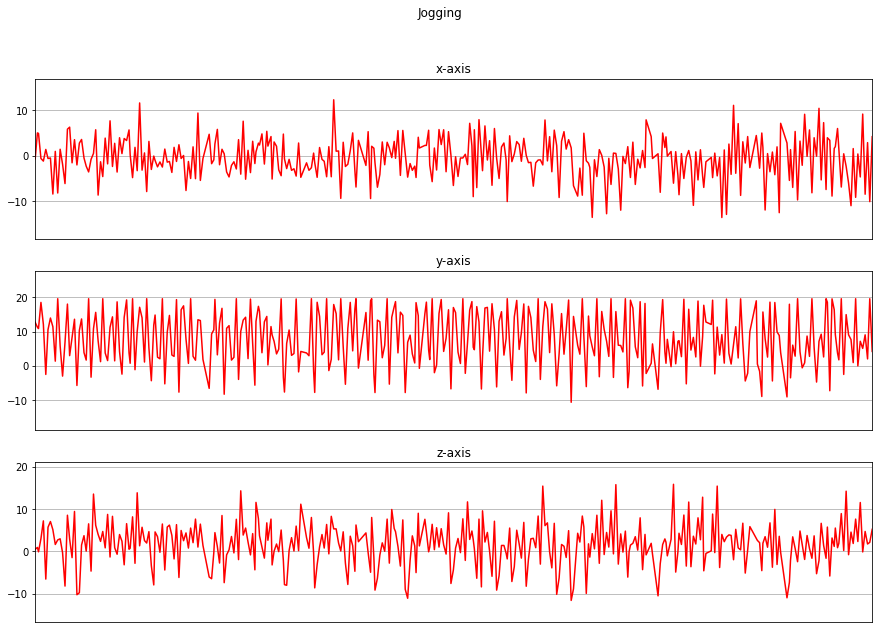

0          False
1          False
2          False
3          False
4          False
           ...  
1098199    False
1098200    False
1098201    False
1098202    False
1098203    False
Name: activity, Length: 1098204, dtype: bool      user-id activity       timestamp         X          Y         Z
597       33  Walking  49394992294000  0.844462   8.008764  2.792171
598       33  Walking  49395102310000  1.116869   8.621680  3.786457
599       33  Walking  49395202316000 -0.503953  16.657684  1.307553
600       33  Walking  49395302292000  4.794363  10.760075 -1.184970
601       33  Walking  49395412338000 -0.040861   9.234595 -0.694638
..       ...      ...             ...       ...        ...       ...
952       33  Walking  49432432296000 -6.469665  17.202500  1.729784
953       33  Walking  49432542312000 -1.144109  12.067628  0.313268
954       33  Walking  49432652298000  0.381370   8.430995 -1.416516
955       33  Walking  49432762283000 -0.081722  10.691973  0.721878
956      

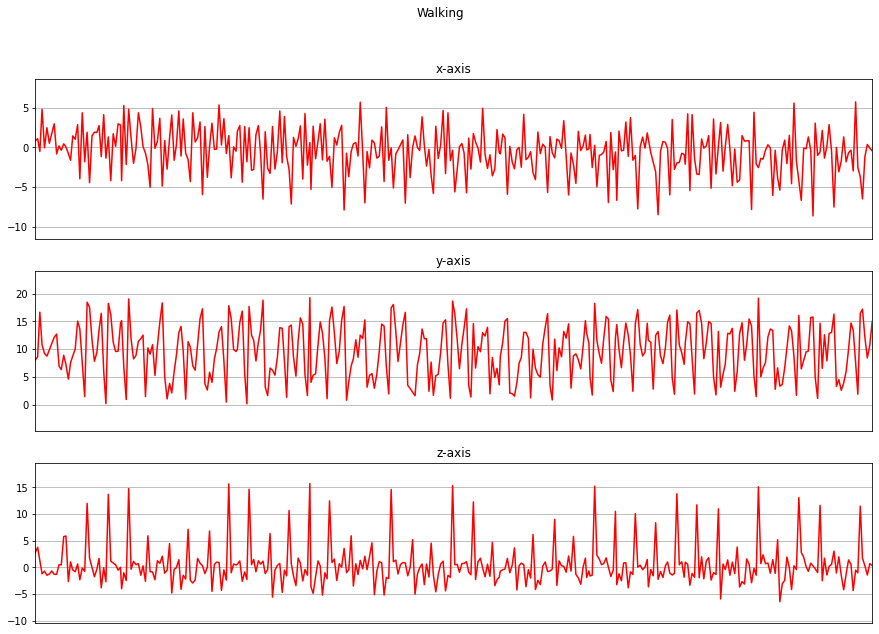

0          False
1          False
2          False
3          False
4          False
           ...  
1098199    False
1098200    False
1098201    False
1098202    False
1098203    False
Name: activity, Length: 1098204, dtype: bool       user-id  activity       timestamp          X          Y         Z
1161       33  Upstairs  49560572311000  10.119919   4.331271 -3.786457
1162       33  Upstairs  49560682449000   4.862464   3.909040 -2.792171
1163       33  Upstairs  49560782303000   9.466142  13.402422 -3.827318
1164       33  Upstairs  49560842209000   5.747787   7.627395 -3.146300
1165       33  Upstairs  49560942184000   2.301839   8.921328 -3.023717
...       ...       ...             ...        ...        ...       ...
1516       33  Upstairs  49597212265000   2.833032   8.962189  1.539099
1517       33  Upstairs  49597322311000   2.683209   8.308413  0.081722
1518       33  Upstairs  49597422317000   1.607201   9.915613  1.539099
1519       33  Upstairs  49597532303000   4.2495

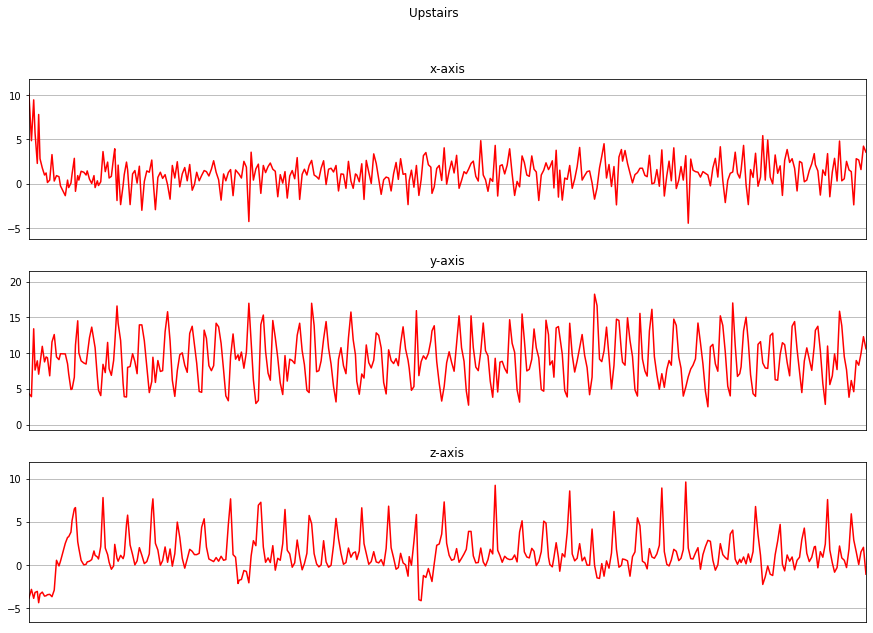

0          False
1          False
2          False
3          False
4          False
           ...  
1098199    False
1098200    False
1098201    False
1098202    False
1098203    False
Name: activity, Length: 1098204, dtype: bool       user-id    activity       timestamp         X          Y         Z
1769       33  Downstairs  49646322311000 -0.040861   4.985047  6.510526
1770       33  Downstairs  49646422317000 -0.463092   4.372132  7.436710
1771       33  Downstairs  49646522323000 -0.299648   4.603678  6.510526
1772       33  Downstairs  49646572281000 -0.272407   4.481094  6.360703
1773       33  Downstairs  49646672317000 -1.525479   5.175732  7.164303
...       ...         ...             ...       ...        ...       ...
2124       33  Downstairs  49683342300000 -1.525479   7.586533  4.562817
2125       33  Downstairs  49683452347000 -3.255263   9.343558  2.533385
2126       33  Downstairs  49683562301000  0.503953  17.965239  4.944186
2127       33  Downstairs  49683662277

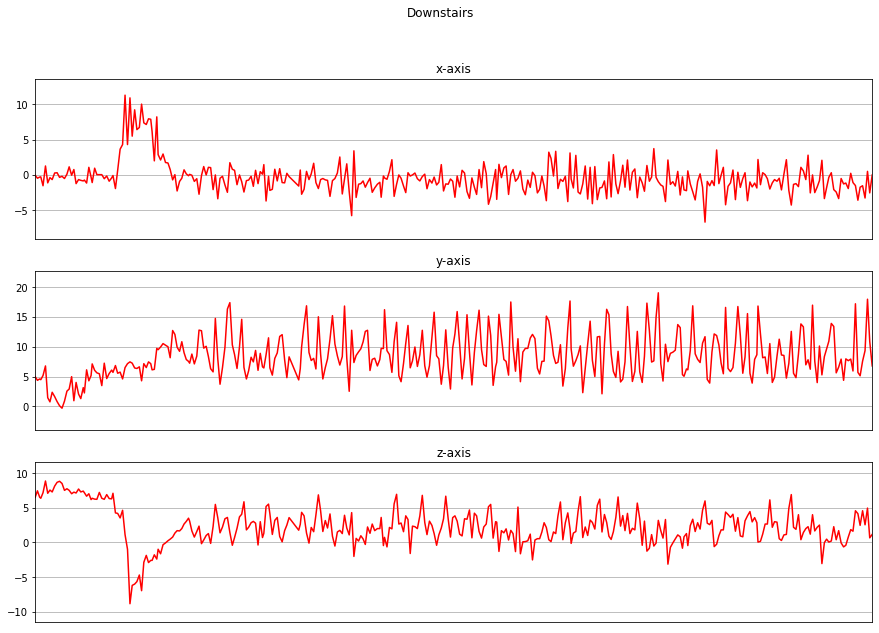

0          False
1          False
2          False
3          False
4          False
           ...  
1098199     True
1098200     True
1098201     True
1098202     True
1098203     True
Name: activity, Length: 1098204, dtype: bool         user-id activity       timestamp     X     Y         Z
221333       27  Sitting  12363992261000  2.60  9.66  1.035146
221334       27  Sitting  12364042279000  2.68  9.53  0.503953
221335       27  Sitting  12364092267000  3.49  8.89  0.762740
221336       27  Sitting  12364142316000  3.64  9.38  0.926184
221337       27  Sitting  12364192273000  2.91  9.34  1.035146
...         ...      ...             ...   ...   ...       ...
221688       27  Sitting  12381762220000  3.15  9.28  1.184970
221689       27  Sitting  12381812268000  3.15  9.38  1.225831
221690       27  Sitting  12381862256000  3.11  9.28  1.184970
221691       27  Sitting  12381912274000  3.17  9.30  1.266692
221692       27  Sitting  12381962232000  3.15  9.34  1.225831

[360 rows x

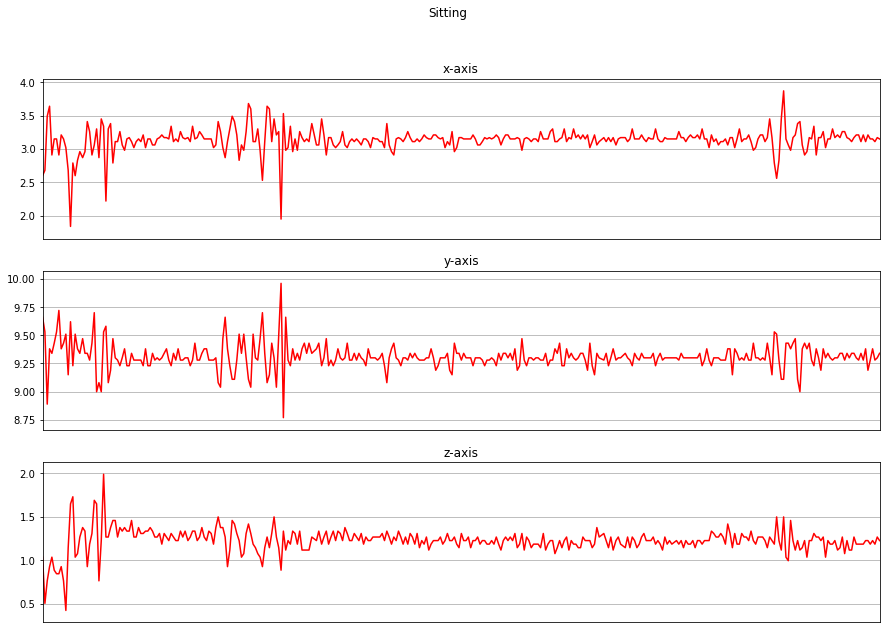

0          False
1          False
2          False
3          False
4          False
           ...  
1098199    False
1098200    False
1098201    False
1098202    False
1098203    False
Name: activity, Length: 1098204, dtype: bool         user-id  activity       timestamp     X      Y         Z
223432       27  Standing  12535892255000 -1.88   9.85 -0.231546
223433       27  Standing  12535942273000 -0.19   9.92 -0.572055
223434       27  Standing  12535992231000 -0.61  10.27 -0.885323
223435       27  Standing  12536042310000  0.76  10.57 -1.757025
223436       27  Standing  12536092206000  0.42   9.47 -1.116869
...         ...       ...             ...   ...    ...       ...
223787       27  Standing  12553632245000  0.42   9.92 -1.757025
223788       27  Standing  12553632245000  0.42   9.92 -1.757025
223789       27  Standing  12553732129000  0.34   9.89 -1.757025
223790       27  Standing  12553782209000  0.89   9.89 -1.607201
223791       27  Standing  12553842298000  0.95  10.0

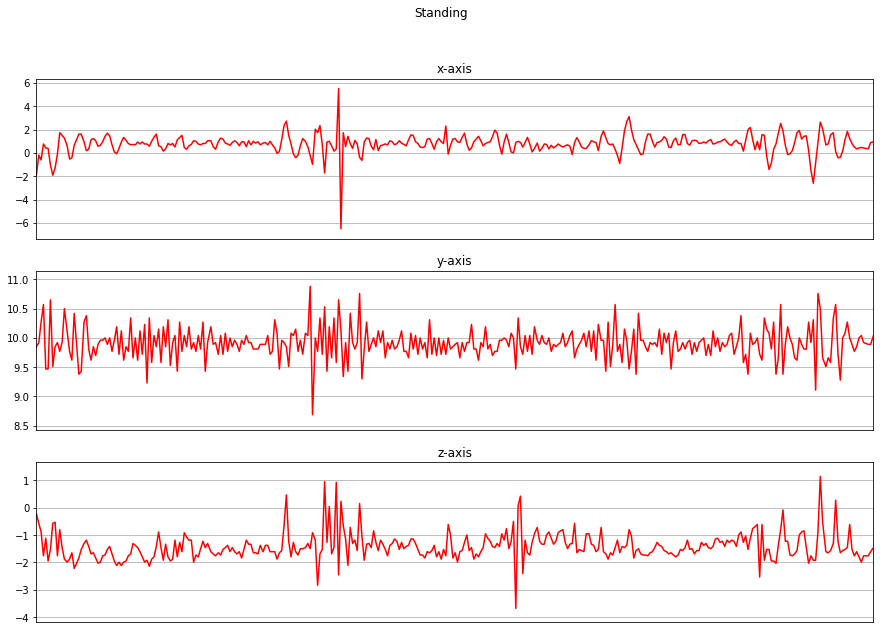

In [ ]:
for activity in df['activity'].unique():
    # 将表中activity等于的全部设置为True，同时取前180*2个
    limit = df[df['activity'] == activity][:360]
    print(df['activity'] == activity,limit)
    # nrow表示有3行，sharex表示共享x轴
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True, figsize=(15, 10))
    axis_plot(ax0, limit['timestamp'], limit['X'], 'x-axis')
    axis_plot(ax1, limit['timestamp'], limit['Y'], 'y-axis')
    axis_plot(ax2, limit['timestamp'], limit['Z'], 'z-axis')
    # plt的调整，但是这里写的都是默认值，所以其实甚至没必要写
    # plt.subplots_adjust(hspace=0.2)
    # 加一个最大的标题
    fig.suptitle(activity)
    # plt.subplots_adjust(top=0.9)
    plt.show()

# Data Preprocessing

## Label Encoding

In [ ]:
label_encode = LabelEncoder()
# df['activity'].values.ravel()将act里面的数据从Series转化为ndarray类型
print(df['activity'].values.ravel(),len(df['activity'].values.ravel()))
# fit_transform(y)中的y是like-array类型，因此才进行转化的，其实不转化也是可以的
df['activityEncode'] = label_encode.fit_transform(df['activity'].values.ravel())
df

['Jogging' 'Jogging' 'Jogging' ... 'Sitting' 'Sitting' 'Sitting'] 1098204


,user-id,activity,timestamp,X,Y,Z,activityEncode
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,1
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,1
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,1
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,1
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,1
...,...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,9.000000,-1.570000,1.690000,2
1098200,19,Sitting,131623371431000,9.040000,-1.460000,1.730000,2
1098201,19,Sitting,131623411592000,9.080000,-1.380000,1.690000,2
1098202,19,Sitting,131623491487000,9.000000,-1.460000,1.730000,2


## Linear Interpolation

In [ ]:
df.isna().sum()

user-id           0
activity          0
timestamp         0
X                 0
Y                 0
Z                 1
activityEncode    0
dtype: int64

In [ ]:
# 拟合函数,用activityEncode拟合df[Z]的值
interpolation_fn = interp1d(df['activityEncode'] ,df['Z'], kind='linear')
interpolation_fn(5)

array(2.7921712)

In [ ]:
tttt = df[df['Z'].isnull()].index[0]


In [ ]:

df['activityEncode'][343416]

5

In [ ]:
tttt = df['activityEncode'][tttt]
print(tttt)

5


In [ ]:
null_list = df[df['Z'].isnull()].index.tolist()
null_list

[343416]

In [ ]:
# 用拟合函数填充na
for i in null_list:
    y = df['activityEncode'][i]
    value = interpolation_fn(y)
    df['Z']=df['Z'].fillna(value)
    print(value)

2.7921712000000003


In [ ]:
df.isna().sum()

user-id           0
activity          0
timestamp         0
X                 0
Y                 0
Z                 0
activityEncode    0
dtype: int64

## Dataset split

In [ ]:
## train split users between 1 and 27, test split users between 28 and 33
df_test = df[df['user-id'] > 27]
df_train = df[df['user-id'] <= 27]
print(df_test.shape,df_train.shape)

(284781, 7) (813423, 7)


## Normalization

In [ ]:
# 归一化
df_train['X'] = (df_train['X']-df_train['X'].min())/(df_train['X'].max()-df_train['X'].min())
df_train['Y'] = (df_train['Y']-df_train['Y'].min())/(df_train['Y'].max()-df_train['Y'].min())
df_train['Z'] = (df_train['Z']-df_train['Z'].min())/(df_train['Z'].max()-df_train['Z'].min())
df_train

,user-id,activity,timestamp,X,Y,Z,activityEncode
8489,17,Walking,57869902574000,0.510163,0.741908,0.488932,5
8490,17,Walking,57870012316000,0.495703,0.751526,0.487895,5
8491,17,Walking,57870122301000,0.489850,0.742938,0.484785,5
8492,17,Walking,57870222246000,0.499490,0.748778,0.489623,5
8493,17,Walking,57870332292000,0.499490,0.750496,0.486858,5
...,...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,0.723205,0.454981,0.545293,2
1098200,19,Sitting,131623371431000,0.724216,0.457755,0.546308,2
1098201,19,Sitting,131623411592000,0.725228,0.459773,0.545293,2
1098202,19,Sitting,131623491487000,0.723205,0.457755,0.546308,2


In [ ]:
df_train['activityEncode'].value_counts()

5    314341
1    262651
4     90906
0     71436
2     41932
3     32157
Name: activityEncode, dtype: int64

In [ ]:
print(df_train['activityEncode'].values[0:120])
print(mode(df_train['activityEncode'][0:120])[0][0])
# 找到对应列表中的出现次数最多的数

[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5]
5


## Segmentation

In [ ]:
a = np.array([[2, 2, 2, 1],
              [1, 2, 2, 2],
              [1, 1, 3, 3]])
print("# Print mode(a):", mode(a))
print("# Print mode(a.transpose()):", mode(a.transpose()))
print("# a的每一列中最常见的成员为：{}，分别出现了{}次。".format(mode(a)[0][0], mode(a)[1][0]))
print("# a的第一列中最常见的成员为：{}，出现了{}次。".format(mode(a)[0][0][0], mode(a)[1][0][0]))
print("# a的每一行中最常见的成员为：{}，分别出现了{}次。".format(mode(a.transpose())[0][0], mode(a.transpose())[1][0]))
print("# a中最常见的成员为：{}，出现了{}次。".format(mode(a.reshape(-1))[0][0], mode(a.reshape(-1))[1][0]))
 
# a的每一列中最常见的成员为：[1 2 2 1]，分别出现了[2 2 2 1]次。
# a的第一列中最常见的成员为：1，出现了2次。
# a的每一行中最常见的成员为：[2 2 1]，分别出现了[3 3 2]次。
# a中最常见的成员为：2，出现了6次。

# Print mode(a): ModeResult(mode=array([[1, 2, 2, 1]]), count=array([[2, 2, 2, 1]]))
# Print mode(a.transpose()): ModeResult(mode=array([[2, 2, 1]]), count=array([[3, 3, 2]]))
# a的每一列中最常见的成员为：[1 2 2 1]，分别出现了[2 2 2 1]次。
# a的第一列中最常见的成员为：1，出现了2次。
# a的每一行中最常见的成员为：[2 2 1]，分别出现了[3 3 2]次。
# a中最常见的成员为：2，出现了6次。


In [ ]:
# 12.4
def segments(df, time_steps, step, label_name):
    N_FEATURES = 3
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['X'].values[i:i+time_steps]
        ys = df['Y'].values[i:i+time_steps]
        zs = df['Z'].values[i:i+time_steps]
        
        # 找到df[label_name][i:i+time_steps]这个列表中出现次数最多的那个数字（如果有相同次数则输入最小的数字）
        label = mode(df[label_name][i:i+time_steps])[0][0]
        segments.append([xs, ys, zs])
        if i==0:
          print(segments,len(segments),np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES))
        labels.append(label)
    
    # 原来segments的维度为(N, 3, time_steps)==>现在更改为(N,time_stpes,3)，不是转置，相当于先把多维数组展开成1维后
    # 再根据需要变换的维度进行改变
    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)

    labels = np.asarray(labels)
    
    return reshaped_segments, labels

In [ ]:
TIME_PERIOD = 80
STEP_DISTANCE = 40
LABEL = 'activityEncode'
x_train, y_train = segments(df_train, TIME_PERIOD, STEP_DISTANCE, LABEL)


[[array([0.51016316, 0.49570273, 0.4898497 , 0.49948999, 0.49948999,
       0.51119605, 0.4984571 , 0.49294836, 0.49363695, 0.50362154,
       0.50431013, 0.50534302, 0.50258865, 0.50534302, 0.50844168,
       0.50740879, 0.50844168, 0.50534302, 0.50362154, 0.50913027,
       0.50913027, 0.51016316, 0.50534302, 0.50740879, 0.51326182,
       0.50844168, 0.50913027, 0.50740879, 0.5063759 , 0.5063759 ,
       0.50431013, 0.50740879, 0.50913027, 0.50844168, 0.50258865,
       0.50155576, 0.50844168, 0.50052287, 0.49363695, 0.49294836,
       0.5325424 , 0.53460817, 0.55664311, 0.591417  , 0.56043037,
       0.53460817, 0.53942831, 0.51704908, 0.49776851, 0.54803572,
       0.55561022, 0.56731629, 0.56249615, 0.57041495, 0.49466984,
       0.53150951, 0.54700283, 0.49363695, 0.50913027, 0.52565648,
       0.57695657, 0.50913027, 0.52772225, 0.62068215, 0.67576951,
       0.50155576, 0.5149833 , 0.54321557, 0.4984571 , 0.47435638,
       0.56731629, 0.58590827, 0.51016316, 0.54700283, 0.569

In [ ]:
x_train[0], x_train[0].shape

(array([[0.5101632 , 0.49570274, 0.4898497 ],
        [0.49949   , 0.49949   , 0.5111961 ],
        [0.4984571 , 0.49294835, 0.49363697],
        [0.5036215 , 0.50431013, 0.505343  ],
        [0.5025886 , 0.505343  , 0.5084417 ],
        [0.5074088 , 0.5084417 , 0.505343  ],
        [0.5036215 , 0.5091303 , 0.5091303 ],
        [0.5101632 , 0.505343  , 0.5074088 ],
        [0.5132618 , 0.5084417 , 0.5091303 ],
        [0.5074088 , 0.5063759 , 0.5063759 ],
        [0.50431013, 0.5074088 , 0.5091303 ],
        [0.5084417 , 0.5025886 , 0.50155574],
        [0.5084417 , 0.50052285, 0.49363697],
        [0.49294835, 0.5325424 , 0.5346082 ],
        [0.5566431 , 0.591417  , 0.56043035],
        [0.5346082 , 0.5394283 , 0.5170491 ],
        [0.4977685 , 0.54803574, 0.55561024],
        [0.5673163 , 0.5624961 , 0.57041496],
        [0.49466985, 0.5315095 , 0.54700285],
        [0.49363697, 0.5091303 , 0.52565646],
        [0.57695657, 0.5091303 , 0.52772224],
        [0.6206822 , 0.6757695 , 0

In [ ]:
x_train,y_train

(array([[[0.5101632 , 0.49570274, 0.4898497 ],
         [0.49949   , 0.49949   , 0.5111961 ],
         [0.4984571 , 0.49294835, 0.49363697],
         ...,
         [0.4187738 , 0.5103595 , 0.451952  ],
         [0.49653524, 0.4567905 , 0.44123822],
         [0.49653524, 0.5276398 , 0.6289025 ]],
 
        [[0.5325424 , 0.5346082 , 0.5566431 ],
         [0.591417  , 0.56043035, 0.5346082 ],
         [0.5394283 , 0.5170491 , 0.4977685 ],
         ...,
         [0.3973462 , 0.47510764, 0.43052444],
         [0.48582146, 0.5158892 , 0.40045667],
         [0.48685828, 0.4733796 , 0.6385795 ]],
 
        [[0.54700285, 0.5566431 , 0.47538927],
         [0.5566431 , 0.63514256, 0.5711035 ],
         [0.52186924, 0.5421827 , 0.5149833 ],
         ...,
         [0.39838302, 0.4986089 , 0.50724906],
         [0.4937704 , 0.4567905 , 0.47925493],
         [0.49653524, 0.56669337, 0.68039787]],
 
        ...,
 
        [[0.73028314, 0.7259858 , 0.7163802 ],
         [0.72219414, 0.71840245, 0.72017

## Data reshaping

In [ ]:
print('x_train shape:', x_train.shape)
print('Training samples:', x_train.shape[0])
print('y_train shape:', y_train.shape)

x_train shape: (20334, 80, 3)
Training samples: 20334
y_train shape: (20334,)


In [ ]:
## Input and Output Dimensions
time_period, sensors = x_train.shape[1], x_train.shape[2]
print(time_period, sensors)
# 6个活动类
num_classes = label_encode.classes_.size
print(list(label_encode.classes_))

80 3
['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']


In [ ]:
## reshaping data
input_shape = time_period * sensors
# 直接把x y z各80个数据全部展开，成为一个240长度的
x_train = x_train.reshape(x_train.shape[0], input_shape)
print(x_train[0],x_train.shape)
print("Input Shape: ", input_shape)
print("Input Data Shape: ", x_train.shape)

[0.5101632  0.49570274 0.4898497  0.49949    0.49949    0.5111961
 0.4984571  0.49294835 0.49363697 0.5036215  0.50431013 0.505343
 0.5025886  0.505343   0.5084417  0.5074088  0.5084417  0.505343
 0.5036215  0.5091303  0.5091303  0.5101632  0.505343   0.5074088
 0.5132618  0.5084417  0.5091303  0.5074088  0.5063759  0.5063759
 0.50431013 0.5074088  0.5091303  0.5084417  0.5025886  0.50155574
 0.5084417  0.50052285 0.49363697 0.49294835 0.5325424  0.5346082
 0.5566431  0.591417   0.56043035 0.5346082  0.5394283  0.5170491
 0.4977685  0.54803574 0.55561024 0.5673163  0.5624961  0.57041496
 0.49466985 0.5315095  0.54700285 0.49363697 0.5091303  0.52565646
 0.57695657 0.5091303  0.52772224 0.6206822  0.6757695  0.50155574
 0.5149833  0.5432156  0.4984571  0.47435638 0.5673163  0.5859083
 0.5101632  0.54700285 0.5693821  0.63720834 0.45989594 0.5983029
 0.49949    0.6168949  0.74190795 0.75152636 0.74293846 0.7487783
 0.7504958  0.7456866  0.74671715 0.7477477  0.7498088  0.74671715
 0.7467

In [ ]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')
print(y_train,y_train.shape)

[5. 5. 5. ... 2. 2. 2.] (20334,)


## One-Hot Encoding

In [ ]:
y_train_hot = to_categorical(y_train, num_classes)
# 转化为独热编码，一行只有对应的那个类别为1
print(y_train_hot)
print("y_train shape: ", y_train_hot.shape)

[[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 ...
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]
y_train shape:  (20334, 6)


# Model

In [ ]:
# 12.5
model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=(input_shape,1), activation='relu'))
model.add(LSTM(32,return_sequences=True, activation='relu'))
model.add(Reshape((1, 240, 32)))
model.add(Conv1D(filters=64,kernel_size=2, activation='relu', strides=2))
model.add(Reshape((120, 64)))
model.add(MaxPool1D(pool_size=4, padding='same'))
model.add(Conv1D(filters=192, kernel_size=2, activation='relu', strides=1))
model.add(Reshape((29, 192)))
model.add(GlobalAveragePooling1D())
model.add(BatchNormalization(epsilon=1e-06))
model.add(Dense(6))
model.add(Activation('softmax'))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 240, 32)           4352      
                                                                 
 lstm_3 (LSTM)               (None, 240, 32)           8320      
                                                                 
 reshape_3 (Reshape)         (None, 1, 240, 32)        0         
                                                                 
 conv1d_2 (Conv1D)           (None, 1, 120, 64)        4160      
                                                                 
 reshape_4 (Reshape)         (None, 120, 64)           0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 30, 64)           0         
 1D)                                                             
                                                      

## Training

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

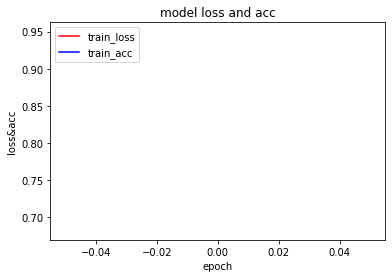

Epoch 1/10
106/106 [==============================] - 78s 731ms/step - loss: 0.4885 - accuracy: 0.8227
Epoch 2/10
106/106 [==============================] - 78s 736ms/step - loss: 0.4554 - accuracy: 0.8333
Epoch 3/10
106/106 [==============================] - 80s 752ms/step - loss: 0.4032 - accuracy: 0.8528
Epoch 4/10
106/106 [==============================] - 95s 894ms/step - loss: 0.3783 - accuracy: 0.8611
Epoch 5/10
106/106 [==============================] - 79s 745ms/step - loss: 0.3516 - accuracy: 0.8696
Epoch 6/10
106/106 [==============================] - 78s 732ms/step - loss: 0.3339 - accuracy: 0.8768
Epoch 7/10
106/106 [==============================] - 76s 721ms/step - loss: 0.3203 - accuracy: 0.8833
Epoch 8/10
106/106 [==============================] - 105s 995ms/step - loss: 0.3121 - accuracy: 0.8836
Epoch 9/10
106/106 [==============================] - 77s 729ms/step - loss: 0.2980 - accuracy: 0.8880
Epoch 10/10
106/106 [==============================] - 87s 822ms/step - 

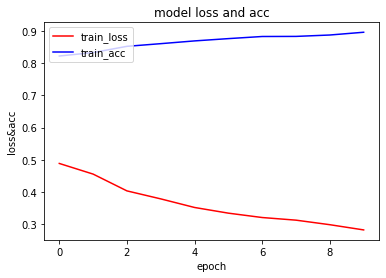

In [ ]:
history = model.fit(x_train,
                    y_train_hot, 
                    batch_size= 192, 
                    epochs=10
                   )
plt.figure()
plt.plot(history.history['loss'],color='r')
plt.plot(history.history['accuracy'],color='b')

plt.title('model loss and acc')
plt.ylabel('loss&acc')
plt.xlabel('epoch')
plt.legend(['train_loss','train_acc'], loc='upper left')
plt.show()

In [ ]:
print(history.history)

{'loss': [0.9490213394165039], 'accuracy': [0.6832890510559082]}


In [ ]:
y_pred_train = model.predict(x_train)
print(f"这就是预测{y_pred_train},长度为{y_pred_train.shape}")
max_y_pred_train = np.argmax(y_pred_train, axis=1)
print(f"这就是softmax预测{max_y_pred_train},长度:{max_y_pred_train.shape}")
print(classification_report(y_train, max_y_pred_train))

636/636 [==============================] - 39s 61ms/step
这就是预测[[4.8192305e-05 4.1174465e-07 2.2167157e-09 3.5719658e-08 3.9798048e-05
  9.9991155e-01]
 [2.7732872e-06 2.2563656e-08 3.2523966e-12 3.0406139e-11 4.1785250e-07
  9.9999678e-01]
 [1.4975460e-06 1.7188682e-08 1.0651462e-12 5.7472417e-12 1.5331476e-07
  9.9999833e-01]
 ...
 [7.6597900e-04 2.4073203e-04 9.8553486e-04 5.5155291e-05 8.4927883e-03
  9.8945975e-01]
 [7.7326392e-04 2.5234566e-04 1.0568065e-03 5.6839726e-05 8.7208375e-03
  9.8913991e-01]
 [7.9755374e-04 2.6665643e-04 1.1335756e-03 6.1045735e-05 9.1692610e-03
  9.8857188e-01]],长度为(20334, 6)
这就是softmax预测[5 5 5 ... 5 5 5],长度:(20334,)
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1788
         1.0       0.99      0.65      0.79      6570
         2.0       0.00      0.00      0.00      1049
         3.0       0.00      0.00      0.00       801
         4.0       0.00      0.00      0.00      2268
         5.0     

In [ ]:
# !pip intall sklearn.meatrics\
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train,max_y_pred_train)

array([[   0,    0,    0,    0,    0, 1788],
       [   0, 4298,    0,    0,    0, 2272],
       [   0,    0,    0,    0,    0, 1049],
       [   0,    0,    0,    0,    0,  801],
       [   0,   23,    0,    0,    0, 2245],
       [   0,    0,    0,    0,    0, 7858]])

为什么没有数组！{'loss': [0.48852989077568054, 0.4554177224636078, 0.40319010615348816, 0.3783165216445923, 0.3515896797180176, 0.3339286744594574, 0.32033243775367737, 0.31214651465415955, 0.2980227470397949, 0.2818063199520111], 'accuracy': [0.8226615786552429, 0.8333333134651184, 0.8527589440345764, 0.8610701560974121, 0.8696272373199463, 0.8767581582069397, 0.8833481073379517, 0.8836431503295898, 0.8879708647727966, 0.8965771794319153]}


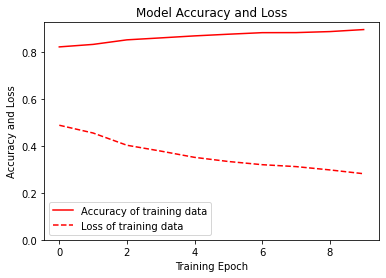

In [ ]:
plt.figure(figsize=(6, 4))
print(f"为什么没有数组！{history.history}")
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

## Test

### Normalize test data

In [ ]:
df_test['X'] = (df_test['X']-df_test['X'].min())/(df_test['X'].max()-df_test['X'].min())
df_test['Y'] = (df_test['Y']-df_test['Y'].min())/(df_test['Y'].max()-df_test['Y'].min())
df_test['Z'] = (df_test['Z']-df_test['Z'].min())/(df_test['Z'].max()-df_test['Z'].min())
df_test

,user-id,activity,timestamp,X,Y,Z,activityEncode
0,33,Jogging,49105962326000,0.478144,0.820181,0.528758,1
1,33,Jogging,49106062271000,0.622404,0.784202,0.540574,1
2,33,Jogging,49106112167000,0.619649,0.774515,0.513362,1
3,33,Jogging,49106222305000,0.480209,0.967905,0.594998,1
4,33,Jogging,49106332290000,0.465749,0.805651,0.704920,1
...,...,...,...,...,...,...,...
832892,31,Standing,25207361641000,0.702983,0.612903,0.519453,3
832893,31,Standing,25207401497000,0.722194,0.600203,0.553891,3
832894,31,Standing,25207441536000,0.697169,0.618745,0.531546,3
832895,31,Standing,25207521553000,0.698180,0.619761,0.533649,3


### Segmentation & Reshaping

In [ ]:
x_test, y_test = segments(df_test,
                         TIME_PERIOD,
                         STEP_DISTANCE,
                         LABEL)

x_test = x_test.reshape(x_test.shape[0], input_shape)
x_test = x_test.astype('float32')
y_test = y_test.astype('float32')
y_test = to_categorical(y_test, num_classes)
print(y_test.shape)

[[array([0.47814364, 0.62240364, 0.61964927, 0.48020941, 0.46574898,
       0.53047662, 0.48020941, 0.48296378, 0.28258354, 0.51980345,
       0.28843655, 0.53150951, 0.44818989, 0.34076955, 0.6430614 ,
       0.65442316, 0.4561087 , 0.58487538, 0.44440263, 0.56559481,
       0.58590827, 0.48296378, 0.43751671, 0.40549719, 0.47538927,
       0.50844168, 0.63996274, 0.27673051, 0.46196173, 0.37967499,
       0.59348278, 0.45025566, 0.68954135, 0.43579524, 0.56456192,
       0.4048086 , 0.59554856, 0.50740879, 0.591417  , 0.58005523,
       0.63892985, 0.50155576, 0.37382196, 0.54218268, 0.41238311,
       0.78904287, 0.41548177, 0.51119605, 0.29635537, 0.57523509,
       0.41926903, 0.49363695, 0.46953624, 0.43372946, 0.46092884,
       0.43269657, 0.5325424 , 0.45989595, 0.46368321, 0.40274283,
       0.54218268, 0.46368321, 0.55664311, 0.48020941, 0.49673562,
       0.30220841, 0.46368321, 0.36900182, 0.54493705, 0.36796893,
       0.73292262, 0.35832864, 0.48020941, 0.61482913, 0.451

### Evaluate

In [ ]:
# 专门用于测试test集
score = model.evaluate(x_test, y_test)
print("Accuracy:", score[1])
print("Loss:", score[0])

223/223 [==============================] - 15s 64ms/step - loss: 1.7960 - accuracy: 0.0636
Accuracy: 0.06364147365093231
Loss: 1.795954704284668


223/223 [==============================] - 17s 75ms/step


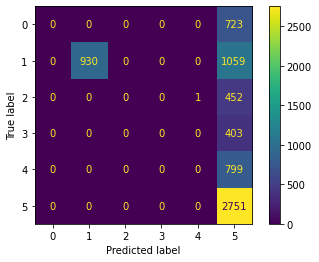

In [ ]:
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
y_test_pred = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test_pred, predictions)
cm_disp = ConfusionMatrixDisplay(confusion_matrix= cm)
cm_disp.plot()
plt.show()

In [ ]:
print(classification_report(y_test_pred, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       723
           1       1.00      0.47      0.64      1989
           2       0.00      0.00      0.00       453
           3       0.00      0.00      0.00       403
           4       0.00      0.00      0.00       799
           5       0.44      1.00      0.62      2751

    accuracy                           0.52      7118
   macro avg       0.24      0.24      0.21      7118
weighted avg       0.45      0.52      0.42      7118

